**Machine Learning Project - Garbage Classification using CNN**

In [ ]:
import torch, torchvision, torchvision.transforms as transforms, torch.nn as nn, torch.optim as optim, os, zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader, random_split
from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
drive.mount('/content/drive')
zip_path = '/content/drive/My Drive/Colab Notebooks/archive.zip'
extract_path = '/content/garbage_data/garbage-dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
numEpochs = 50
learningRate = 0.0001
batchSize = 128

In [ ]:
imagePipeline = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

class GarbageCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=65536, out_features = 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Using device:  cuda
Computed Weights:  [2.0934322  1.98214644 1.08284932 0.37097804 0.64560601 1.93745098
 1.17630952 0.99606855 0.99959535 2.08680042]
Starting training
Epoch:  0  Training Loss:  2.086297547624957  Validaton Accuracy:  0.45433847710599545
Epoch:  1  Training Loss:  1.6702246742863809  Validaton Accuracy:  0.462180622312168
Epoch:  2  Training Loss:  1.5376224027525993  Validaton Accuracy:  0.529724260055654
Epoch:  3  Training Loss:  1.454216581198477  Validaton Accuracy:  0.5451555780419934
Epoch:  4  Training Loss:  1.3679107542960875  Validaton Accuracy:  0.5613458133063496
Epoch:  5  Training Loss:  1.3024708926677704  Validaton Accuracy:  0.5560333923602327
Epoch:  6  Training Loss:  1.2533939086621808  Validaton Accuracy:  0.5777890209967114
Epoch:  7  Training Loss:  1.190640696594792  Validaton Accuracy:  0.5962560080951176
Epoch:  8  Training Loss:  1.1427584035742668  Validaton Accuracy:  0.622818112825702
Epoch:  9  Training Loss:  1.090993871131251  Valida

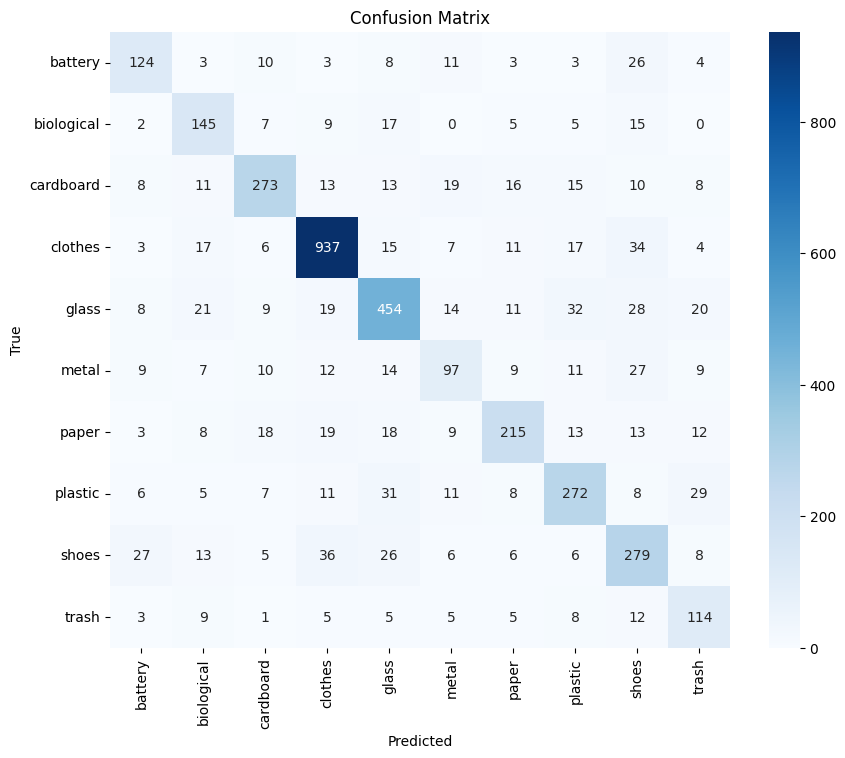

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)
fullDataset = torchvision.datasets.ImageFolder("/content/garbage_data/garbage-dataset", transform=imagePipeline)
trainSize = int(0.8 * len(fullDataset))
testSize = len(fullDataset) - trainSize
trainDataset, testDataset = random_split(fullDataset, [trainSize, testSize])

loadTrainData = DataLoader(
    dataset=trainDataset,
    batch_size=batchSize,
    shuffle=True,
    num_workers = 4
)
loadTestData= DataLoader(
    dataset=testDataset,
    batch_size=batchSize,
    num_workers = 4
)

yIndices = fullDataset.targets
classCounts = np.bincount(yIndices)
totalSamples = len(yIndices)
numClasses = len(classCounts)
classWeights = totalSamples / (numClasses * classCounts)
classWeightsTensor = torch.Tensor(classWeights).to(device)
print("Computed Weights: ", classWeights)

model = GarbageCNN().to(device)
criterion = nn.CrossEntropyLoss(weight=classWeightsTensor)
optimizer = optim.RMSprop(model.parameters(), lr=learningRate, weight_decay=1e-5)

print("Starting training")
bestAccuracy = 0
for epoch in range(numEpochs):
    model.train()
    runningLoss = 0
    for inputs, labels in loadTrainData:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    trainingLoss = runningLoss / len(loadTrainData)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
      for inputs, labels in loadTestData:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
    validationAccuracy = correct / total
    print("Epoch: ", epoch, " Training Loss: ", trainingLoss, " Validaton Accuracy: ", validationAccuracy)
    if validationAccuracy > bestAccuracy:
      bestAccuracy = validationAccuracy
      torch.save(model.state_dict(), 'best_model.pth')
print("Finished training")
print("Final Accuracy: ", bestAccuracy)

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
yTrue = []
yPred = []
with torch.no_grad():
    for inputs, labels in loadTestData:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        yTrue.extend(labels.cpu().numpy())
        yPred.extend(predicted.cpu().numpy())
classNames = fullDataset.classes
print(classification_report(yTrue, yPred, target_names=classNames))
cm = confusion_matrix(yTrue, yPred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classNames, yticklabels=classNames)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()